# LULESH Jupyter Notebook
Author(s) : Caleb Bean, Benjamin Hicks   
Purpose: Python code used to generate slurm job scripts, execute them, parse outputs, and plot meaningful data
## High level Job Execution Setup

In [12]:
# Meant for use on Python 3.10.8
# lulesh.ipynb

import subprocess
import os
import matplotlib.pyplot as plt
import numpy as np


make_cmd = 'MPI' # Options = 'SERIAL', 'MPI', 'OMP', 'MPI+OMP'

job_directory = '../LULESH/'
job_file_name = 'job-hw.sh'
job_path = job_directory+job_file_name

plot_directory = '../plots/'

email = 'caleb.bean@ufl.edu'

outfile_prefix = 'lulesh_out' # Note that currently outfiles do not get produced and the output is only available via stdout
errfile_prefix = 'lulesh_err'
slurmrun_cmd = 'srun ./lulesh2.0 -s '

# Outputs we wish to track (MUST be printed stdout in form Foo=X where X is floating point data to be captured)
outputs_track = [
                'Time',
                'Cycles'
                ]

# outputs_dict used to store all parsed outputs
outputs_dict = {}
for output in outputs_track:
    outputs_dict[output] = []

In [13]:
# SBATCH parameters
# Serial case
lulesh_s_param = [5,8]
# lulesh_s_param = [5,8,10,12,14,16,18,20,22,25,32,48]
nodes_param = [1]*len(lulesh_s_param)
n_tasks_param = [1]*len(lulesh_s_param)
n_taskspernode_param = [1]*len(lulesh_s_param)

job_count = len(lulesh_s_param)

## Function and variable declerations for code build and slurm execution and output parsing

In [14]:
sbatch_cmds_dict = {
    '#!/bin/bash'                           : [],
    '#SBATCH --mail-type=FAIL'              : [],
    '#SBATCH --mail-user='+email            : [],
    '#SBATCH --account=eel6763'             : [],
    '#SBATCH --qos=eel6763'                 : [],
    '#SBATCH --nodes='                      : nodes_param, # Fill this
    '#SBATCH --ntasks='                     : n_tasks_param, # Fill this
    '#SBATCH --ntasks-per-node='            : n_taskspernode_param, # Fill this
    '#SBATCH --cpus-per-task=1'             : [],
    '#SBATCH --mem-per-cpu=500mb'           : [],
    '#SBATCH -t 00:05:00'                   : [],
    '#SBATCH -o '+outfile_prefix            : list(range(job_count)),
    '#SBATCH -e '+errfile_prefix            : list(range(job_count)),
    slurmrun_cmd                            : lulesh_s_param, # Fill this
    }


def buildCode(make_cmd, job_dir):

    if(make_cmd == "SERIAL"):
        make = subprocess.run(['make clean -f serial_make.mk'], shell=True, cwd=job_dir)
        make = subprocess.run(['make -f serial_make.mk'], shell=True, cwd=job_dir)

    elif(make_cmd == "MPI"):
        # NOT CURRENTLY WORKING (check the make file)
        make = subprocess.run(['make clean -f mpi_make.mk'], shell=True, cwd=job_dir)
        make = subprocess.run(['make -f mpi_make.mk'], shell=True, cwd=job_dir)
    # else if(make_cmd == "OMP"):
# 
    # else if(make_cmd == "MPI+OMP"):

    else:
        raise ValueError('Incorrect input names to make cmd')

def genSlurmCmds(sbatch_cmds_dict : dict, job_count : int):
    # This function converts the vectorized dictionary into individual string arrays to be written to slurm files
    
    slurm_cmds_arr = [[]]*job_count
    
    for i in range(job_count):
        cmd_str_arr = []
        for cmd in sbatch_cmds_dict:

            if(sbatch_cmds_dict[cmd]): cmd_str_arr.append(cmd+str(sbatch_cmds_dict[cmd][i]))
            else: cmd_str_arr.append(cmd)
            
        slurm_cmds_arr[i] = cmd_str_arr

    return slurm_cmds_arr

def genSlurmFile(cmds, path : str):
    with open (path, 'w+') as slurmf: 
        for cmd in cmds:
            slurmf.write(cmd + '\n')

    os.chmod(path, 0o744)


def executeSlurmFile(job_dir, job_name):
    slurm = subprocess.run(['./'+job_name], cwd=job_dir, stdout=subprocess.PIPE, encoding='utf-8') # Should return once complete I think
    slurm.check_returncode() # Ensures process ran and exited properly
    
    output_text = slurm.stdout
    #print(output_text)
    return output_text

def parseOutputText(text: str, out_dict: str):

    lines = text.splitlines()

    for key in out_dict:
        for line in lines:
            if key in line:
                temp = line.split(key)[1]
                temp = temp.replace('=','')
                out_dict[key].append(float(temp))
    
    #print(out_dict)



## Code build and execution of each job

In [16]:

buildCode(make_cmd, job_directory)

slurm_cmds_arr = genSlurmCmds(sbatch_cmds_dict, job_count)

for slurm_cmds in slurm_cmds_arr:

    genSlurmFile(slurm_cmds, job_path)
    output_text = executeSlurmFile(job_directory, job_file_name)
    parseOutputText(output_text, outputs_dict)

/bin/rm -f *.o *~  lulesh2.0
/bin/rm -rf *.dSYM
Building lulesh.cc
mpig++ -DUSE_MPI=1 -c  -o lulesh.o  lulesh.cc


make: mpig++: Command not found
make: *** [mpi_make.mk:47: lulesh.o] Error 127
srun: job 29257698 queued and waiting for resources
srun: job 29257698 has been allocated resources
slurmstepd: error: execve(): /home/caleb.bean/PCA/PCA_LULESH/LULESH/./lulesh2.0: No such file or directory
srun: error: c0709a-s3: task 0: Exited with exit code 2


CalledProcessError: Command '['./job-hw.sh']' returned non-zero exit status 2.

## Test setup and plotting

In [ ]:
print(outputs_dict)

{'Time': [0.0049, 0.04], 'Cycles': [72.0, 163.0]}


time/iteration:  [6.80555556e-05 2.45398773e-04]


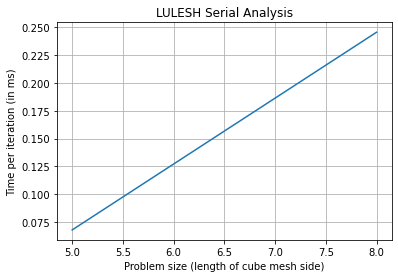

In [ ]:
t = np.array(outputs_dict['Time'])
iterations = np.array(outputs_dict['Cycles'])

print("time/iteration: ", t/iterations)

t_per_iter = (t/iterations)*1000

fig, ax = plt.subplots()
ax.plot(lulesh_s_param, t_per_iter)

ax.set(xlabel='Problem size (length of cube mesh side)', ylabel='Time per iteration (in ms)',
       title='LULESH Serial Analysis')
ax.grid()

fig.savefig(plot_directory+"test.png")

plt.show()
